/tmp/ipython-input-3607256460.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Variant Class')


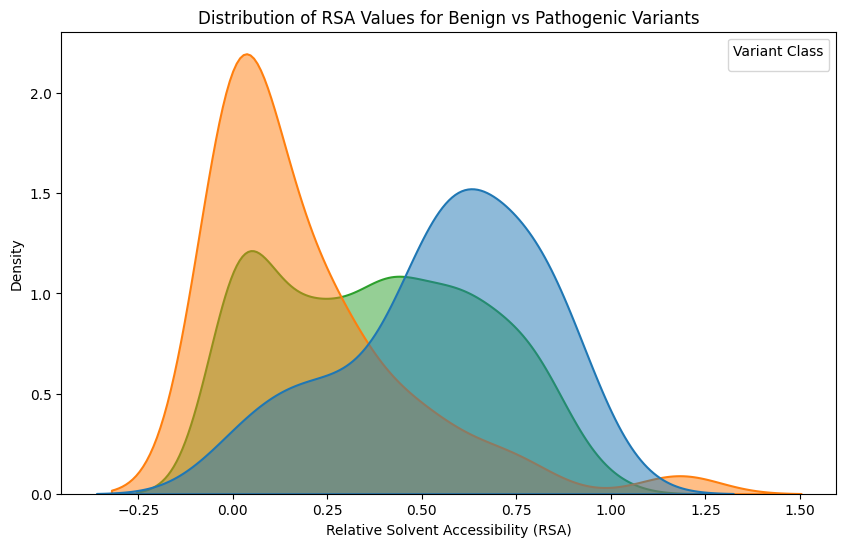

Summary Statistics:
            count      mean       std  min    25%    50%    75%    max
class                                                                 
Benign       41.0  0.561488  0.252555  0.0  0.436  0.597  0.758  0.963
Pathogenic   83.0  0.188072  0.258901  0.0  0.000  0.097  0.264  1.182
VUS         369.0  0.382537  0.278115  0.0  0.127  0.387  0.600  0.995


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets (ensure these files are uploaded in Colab filesystem)
rsa_df = pd.read_csv('nephrin_rsa.csv')
benign_df = pd.read_csv('nphs1_benign.csv')
pathogenic_df = pd.read_csv('nphs1_pathogenic.csv')
vus_df = pd.read_csv('nphs1_vus.csv')

# Merge RSA with benign and pathogenic variant positions
benign_rsa = benign_df.merge(rsa_df, left_on='AA_position', right_on='ResNum', how='left')
pathogenic_rsa = pathogenic_df.merge(rsa_df, left_on='AA_position', right_on='ResNum', how='left')
vus_rsa = vus_df.merge(rsa_df, left_on='AA_position', right_on='ResNum', how='left')

# Combine into a single DataFrame for easier visualization
benign_rsa['class'] = 'Benign'
pathogenic_rsa['class'] = 'Pathogenic'
vus_rsa['class'] = 'VUS'
combined_df = pd.concat([benign_rsa, pathogenic_rsa, vus_rsa], ignore_index=True)

# Visualize RSA distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=combined_df,
    x='RSA',
    hue='class',
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=1.5
)
plt.title('Distribution of RSA Values for Benign vs Pathogenic Variants')
plt.xlabel('Relative Solvent Accessibility (RSA)')
plt.ylabel('Density')
plt.legend(title='Variant Class')
plt.show()

# Summary stats comparison
summary_stats = combined_df.groupby('class')['RSA'].describe()
print("Summary Statistics:")
print(summary_stats)

In [17]:
# Select useful columns for export (you can add/remove columns as needed)
benign_export = benign_rsa[['Name', 'Protein change', 'AA_position', 'RSA']]
pathogenic_export = pathogenic_rsa[['Name', 'Protein change', 'AA_position', 'RSA']]
vus_export = vus_rsa[['Name', 'Protein change', 'AA_position', 'RSA']]

# Optional: remove variants where RSA was not found
benign_export = benign_export.dropna(subset=['RSA'])
pathogenic_export = pathogenic_export.dropna(subset=['RSA'])
vus_export = vus_export.dropna(subset=['RSA'])

# Save to CSV
benign_export.to_csv('benign_with_RSA.csv', index=False)
pathogenic_export.to_csv('pathogenic_with_RSA.csv', index=False)
vus_export.to_csv('vus_with_RSA.csv', index=False)

print("✅ Files saved:")
print(" - benign_with_RSA.csv")
print(" - pathogenic_with_RSA.csv")


✅ Files saved:
 - benign_with_RSA.csv
 - pathogenic_with_RSA.csv


In [12]:
import pandas as pd

# --- Exact PTM residues (single positions) ---
glyco_sites = [40, 356, 401, 547, 553, 564, 577, 680, 708, 908]
phospho_sites = {
    432: "Phosphoserine",
    1098: "Phosphoserine",
    1101: "Phosphothreonine",
    1105: "Phosphoserine",
    1193: "Phosphotyrosine",
}

# Disulfide bonds are pairs of cysteines at these exact positions:
disulfide_pairs = [
    (53, 111),
    (160, 217),
    (265, 317),
    (361, 417),
    (465, 528),
    (567, 623),
    (761, 816),
    (863, 920),
]

# Build a mapping: position -> descriptive PTM label
ptm_map = {}

# Glycosylation (exact N positions)
for pos in glyco_sites:
    ptm_map[pos] = "Glycosylation (N-linked)"

# Phosphorylation (exact positions with residue type)
for pos, label in phospho_sites.items():
    ptm_map[pos] = label

# Disulfide-bond cysteines (each position mapped with its partner)
for a, b in disulfide_pairs:
    ptm_map[a] = f"Disulfide-bonded Cys (paired with {b})"
    ptm_map[b] = f"Disulfide-bonded Cys (paired with {a})"

# Helper to annotate exact PTM
def annotate_ptm_exact(pos: int):
    return ptm_map.get(int(pos), None)

# Annotate both datasets with exact PTM hits
for df in (benign_rsa, pathogenic_rsa):
    df['PTM_exact_match'] = df['AA_position'].apply(annotate_ptm_exact)

# Filter to only exact PTM hits, select useful columns
benign_ptm_exact = benign_rsa.loc[benign_rsa['PTM_exact_match'].notna(),
                                  ['Name', 'Protein change', 'AA_position', 'RSA', 'PTM_exact_match']].copy()
pathogenic_ptm_exact = pathogenic_rsa.loc[pathogenic_rsa['PTM_exact_match'].notna(),
                                          ['Name', 'Protein change', 'AA_position', 'RSA', 'PTM_exact_match']].copy()

# Sort for readability
benign_ptm_exact.sort_values(['AA_position', 'Name'], inplace=True, ignore_index=True)
pathogenic_ptm_exact.sort_values(['AA_position', 'Name'], inplace=True, ignore_index=True)

# Export CSVs
benign_ptm_exact.to_csv("benign_variants_at_exact_PTM_sites.csv", index=False)
pathogenic_ptm_exact.to_csv("pathogenic_variants_at_exact_PTM_sites.csv", index=False)

print("✅ Exported:")
print(" - benign_variants_at_exact_PTM_sites.csv")
print(" - pathogenic_variants_at_exact_PTM_sites.csv")
print("\nCounts (exact PTM hits):")
print(f"  Benign: {len(benign_ptm_exact)}")
print(f"  Pathogenic: {len(pathogenic_ptm_exact)}")


✅ Exported:
 - benign_variants_at_exact_PTM_sites.csv
 - pathogenic_variants_at_exact_PTM_sites.csv

Counts (exact PTM hits):
  Benign: 2
  Pathogenic: 10


In [13]:
# Define protein domains as a list of tuples: (name, start, end)
domains = [
    ("Ig-like C2-type 1", 27, 130),
    ("Ig-like C2-type 2", 143, 234),
    ("Ig-like C2-type 3", 242, 333),
    ("Ig-like C2-type 4", 340, 434),
    ("Ig-like C2-type 5", 440, 540),
    ("Ig-like C2-type 6", 544, 635),
    ("Ig-like C2-type 7", 740, 832),
    ("Ig-like C2-type 8", 838, 939),
    ("Fibronectin type-III", 943, 1038),
    ("Disordered (1025-1057)", 1025, 1057),
    ("Basic/acidic bias (1099-1114)", 1099, 1114),
    ("Disordered (1099-1137)", 1099, 1137),
    ("NPHS2-binding", 1160, 1241)
]

# Function to assign a domain based on position
def assign_domain(pos):
    for name, start, end in domains:
        if start <= pos <= end:
            return name
    return "Outside annotated domains"

# Assign domains to each variant
benign_rsa['Domain'] = benign_rsa['AA_position'].apply(assign_domain)
pathogenic_rsa['Domain'] = pathogenic_rsa['AA_position'].apply(assign_domain)

# Count variants in each domain
benign_counts = benign_rsa['Domain'].value_counts()
pathogenic_counts = pathogenic_rsa['Domain'].value_counts()

# Display the results
print("✅ Benign variant counts by domain:")
print(benign_counts)

print("\n✅ Pathogenic variant counts by domain:")
print(pathogenic_counts)


✅ Benign variant counts by domain:
Domain
Outside annotated domains    10
Ig-like C2-type 1             5
Ig-like C2-type 3             4
Ig-like C2-type 4             4
NPHS2-binding                 4
Ig-like C2-type 2             3
Ig-like C2-type 6             3
Ig-like C2-type 7             3
Disordered (1099-1137)        3
Fibronectin type-III          2
Name: count, dtype: int64

✅ Pathogenic variant counts by domain:
Domain
Outside annotated domains    19
Ig-like C2-type 4            12
Ig-like C2-type 6            11
Ig-like C2-type 7            11
Ig-like C2-type 3             6
Ig-like C2-type 2             5
Ig-like C2-type 1             5
Ig-like C2-type 5             5
Ig-like C2-type 8             4
Fibronectin type-III          4
NPHS2-binding                 1
Name: count, dtype: int64


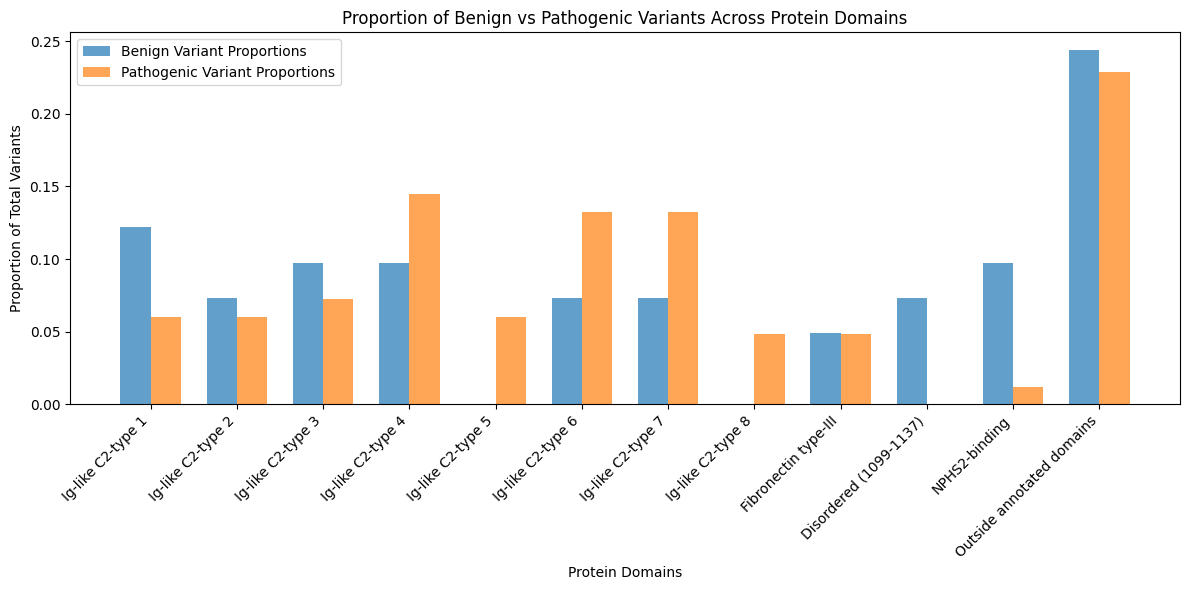

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data for plotting
domain_list = list(set(benign_counts.index).union(set(pathogenic_counts.index)))

# Function to get the index of a domain (used for sorting)
def get_domain_index(domain_name):
    for idx, (name, _, _) in enumerate(domains):
        if name == domain_name:
            return idx
    return len(domains)  # "Outside annotated domains" appears at the end

domain_list = sorted(domain_list, key=get_domain_index)

# Calculate proportions
total_benign = benign_counts.sum()
total_pathogenic = pathogenic_counts.sum()

benign_proportions = [(benign_counts.get(domain, 0) / total_benign) for domain in domain_list]
pathogenic_proportions = [(pathogenic_counts.get(domain, 0) / total_pathogenic) for domain in domain_list]

# Plot
plt.figure(figsize=(12, 6))
x = range(len(domain_list))
width = 0.35

plt.bar(x, benign_proportions, width=width, label='Benign Variant Proportions', alpha=0.7)
plt.bar([p + width for p in x], pathogenic_proportions, width=width, label='Pathogenic Variant Proportions', alpha=0.7)

# Labels and aesthetics
plt.xlabel('Protein Domains')
plt.ylabel('Proportion of Total Variants')
plt.title('Proportion of Benign vs Pathogenic Variants Across Protein Domains')
plt.xticks([p + width / 2 for p in x], domain_list, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()



In [21]:
import pandas as pd

# Prepare data for export
domain_list = list(set(benign_counts.index).union(set(pathogenic_counts.index)))

# Function to get the index of a domain (used for sorting)
def get_domain_index(domain_name):
    for idx, (name, _, _) in enumerate(domains):
        if name == domain_name:
            return idx
    return len(domains)  # places "Outside annotated domains" at the end

# Sort domains based on their position in the protein
domain_list = sorted(domain_list, key=get_domain_index)

# Calculate proportions
total_benign = benign_counts.sum()
total_pathogenic = pathogenic_counts.sum()

data = {
    "Domain": domain_list,
    "Benign_proportion": [(benign_counts.get(domain, 0) / total_benign) for domain in domain_list],
    "Pathogenic_proportion": [(pathogenic_counts.get(domain, 0) / total_pathogenic) for domain in domain_list]
}

df_proportions = pd.DataFrame(data)

# Save to CSV
df_proportions.to_csv('variant_proportion_by_domain.csv', index=False)

print("✅ CSV saved: variant_proportion_by_domain.csv")
print(df_proportions)


✅ CSV saved: variant_proportion_by_domain.csv
                       Domain  Benign_proportion  Pathogenic_proportion
0           Ig-like C2-type 1           0.121951               0.060241
1           Ig-like C2-type 2           0.073171               0.060241
2           Ig-like C2-type 3           0.097561               0.072289
3           Ig-like C2-type 4           0.097561               0.144578
4           Ig-like C2-type 5           0.000000               0.060241
5           Ig-like C2-type 6           0.073171               0.132530
6           Ig-like C2-type 7           0.073171               0.132530
7           Ig-like C2-type 8           0.000000               0.048193
8        Fibronectin type-III           0.048780               0.048193
9      Disordered (1099-1137)           0.073171               0.000000
10              NPHS2-binding           0.097561               0.012048
11  Outside annotated domains           0.243902               0.228916
